## Import

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Lab2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Lab2
cuda:0


## Read / Show Data

In [3]:
def read_bci_data():
  S4b_train = np.load('S4b_train.npz')
  X11b_train = np.load('X11b_train.npz')
  S4b_test = np.load('S4b_test.npz')
  X11b_test = np.load('X11b_test.npz')

  train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
  train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
  test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
  test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

  train_label = train_label - 1
  test_label = test_label -1
  train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
  test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

  mask = np.where(np.isnan(train_data))
  train_data[mask] = np.nanmean(train_data)

  mask = np.where(np.isnan(test_data))
  test_data[mask] = np.nanmean(test_data)
  return train_data, train_label, test_data, test_label

def load_data(param):
  x_train,y_train,x_test,y_test = read_bci_data()
  # print(x_train[:5],y_train[:5])
  train_size,test_size = len(x_train),len(x_test)
  dataset=TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
  train_data = DataLoader(dataset = dataset,batch_size=param["Batch size"],shuffle=True,num_workers=4)
  dataset=TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))
  test_data = DataLoader(dataset = dataset,batch_size=param["Batch size"],shuffle=True,num_workers=4)
  show_data(x_train)

  param['train_data'],param['train_size'] = train_data,train_size
  param['test_data'],param['test_size'] = test_data,test_size

  return param

In [4]:
def show_data(data):
  plt.subplot(2,1,1)
  plt.plot(data[1][0][0])
  plt.subplot(2,1,2)
  plt.plot(data[1][0][0])
  plt.show()
def show_acc(acc,name):
  plt.plot(acc,label=name)  # 每筆資料都有兩張沿時間軸的輸入，看最後是1還是0，所以把這份資料當成圖片輸入， channel=1 圖片大小(2,750)
def show_result(Acc_list,opt):
  for m in ["EEG","DeepCovNet"]:
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy%')
    plt.title(f'Activation function:{m}optimizer:{opt}')
    for act in ["elu","leaky_relu","relu"]:
      for t in ["train","test"]:
        show_acc(Acc_list[m][act][t],act+"_"+t)
    plt.legend()
    plt.show()

  for m in ["EEG","DeepCovNet"]:
    for act in ["elu","leaky_relu","relu"]:
      for t in ["test"]:
        print(m,"_",act,":",max(Acc_list[m][act][t]),"%")
        
def show_relu_result(Acc_list,opt):
  for m in ["EEG"]:
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy%')
    plt.title(f'Activation function:{m}optimizer:{opt}')
    for act in ["relu"]:
      for t in ["train","test"]:
        show_acc(Acc_list[m][act][t],act+"_"+t)
    plt.legend()
    plt.show()

  for m in ["EEG"]:
    for act in ["relu"]:
      for t in ["test"]:
        print(m,"_",act,":",max(Acc_list[m][act][t]),"%")

## Construct Model

In [5]:
class EEG(nn.Module):
    def __init__(self,Activate=None):
        super(EEG,self).__init__()
        print("EEG act:",Activate)
        if not Activate:
          Activate = nn.ELU
        
        # firstconv
        self.firstconv = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=(1,51),stride=(1,1),padding=(0,25),bias=False),
            nn.BatchNorm2d(16,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(2,1),stride=(1,1),groups=16,bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            Activate(),
            nn.AvgPool2d(kernel_size=(1,4),stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32,32,kernel_size=(1,15),stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            Activate(),
            nn.AvgPool2d(kernel_size=(1,8),stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=736,out_features=2,bias=True),
            # nn.soft
        )
    def forward(self,x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.classify(x)
        return x

In [6]:
class DeepCovNet(nn.Module):
    def __init__(self,Activate=None):
        super(DeepCovNet,self).__init__()
        C,T,N = 2,75,2
        print("DeepCovNet act:",Activate)
        if not Activate:
          Activate = nn.ELU
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,25,(1,5),padding='valid'),
            nn.Conv2d(25,25,(C,1),padding='valid'),
            nn.BatchNorm2d(25),
            Activate(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(25,50,(1,5),padding='valid'),
            nn.BatchNorm2d(50),
            Activate(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(50,100,(1,5),padding='valid'),
            nn.BatchNorm2d(100),
            Activate(),
            nn.MaxPool2d(kernel_size=(1,2))
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(100,200,(1,5),padding='valid'),
            nn.BatchNorm2d(200),
            Activate(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
        )
        self.fully = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8600,out_features=2),
        )
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fully(x)
        return x

## Train

In [8]:
def train(model,param):

  Loss,train_data,test_data,train_size,test_size = param["loss"],param['train_data'],param['test_data'],param['train_size'],param['test_size']

  model = model.to(device)
  train_acc_list,test_acc_list = [],[]
  for epoch in range(param["Epochs"]):
      
      if param['optimizer'] == 'Nadam':
        optimizer = torch.optim.NAdam(model.parameters(), lr=param["Learning rate"])
      elif param['optimizer'] == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=param["Learning rate"])
      elif param['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=param["Learning rate"])
      elif param['optimizer'] == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=param["Learning rate"])
      else:
        optimizer = torch.optim.Adam(model.parameters(), lr=param["Learning rate"])

      train_loss,train_correct,test_correct = 0,0,0
      model.train() #因為有用BN所以需要知道是否在此階段
      for idx,(data,target) in enumerate(train_data):
          
          data=data.to(device,dtype=torch.float)
          target=target.to(device,dtype=torch.long)

          predict = model(data)   #預測
          
          loss = Loss(predict,target) #計算loss
          
          optimizer.zero_grad()   # 阻止回傳梯度流，清空所有被優化過的Variable的梯度，如果不這麼做會把前一次的gradient累加，就會越來越多
          loss.backward()     #導數計算
          optimizer.step()    #更新參數

          train_loss +=loss.item()
          train_correct += (predict.argmax(dim=1)==target).sum().item()

      model.eval()#固定BN用
      for idx,(data,target) in enumerate(test_data):
          data = data.to(device,dtype=torch.float)
          target = target.to(device,dtype=torch.long)
          predict = model(data)
          test_correct += (predict.argmax(dim=1)==target).sum().item()
      train_acc_list.append(round(100*train_correct/train_size,2))
      test_acc_list.append(round(100*test_correct/test_size,2))
      if epoch%10==0:
        print("{:^5} [train_acc]{:6}%   [train_loss]{:6}   [test_acc]{:6}%".format(epoch,train_acc_list[-1],round(train_loss,2),test_acc_list[-1]))
      elif epoch == param["Epochs"]-1:
        print("{:^5} [train_acc]{:6}%   [train_loss]{:6}   [test_acc]{:6}%".format(epoch,train_acc_list[-1],round(train_loss,2),test_acc_list[-1]))
        
      # if  test_acc_list[-1]>=param['bound']:
      #   print("comverge! At",end=" ")
      #   print("{:^5} [train_acc]{:6}%   [train_loss]{:6}   [test_acc]{:6}%".format(epoch,train_acc_list[-1],round(train_loss,2),test_acc_list[-1]))
  
  torch.save(model.state_dict(), "./model/eeg_relu.pth")
  return {"train":train_acc_list,"test":test_acc_list,"model":model}


In [9]:
def Run(param,act_list):
  Acc_list={
    "EEG":{},
    "DeepCovNet":{}
  }
  for act in act_list:
      if act=="elu": Activate = nn.ELU
      elif act=="leaky_relu": Activate = nn.LeakyReLU
      elif act=="relu": Activate = nn.ReLU

      Acc_list["EEG"][act]=train(EEG(Activate),param)
      Acc_list["DeepCovNet"][act]=train(DeepCovNet(Activate),param)
      
  return Acc_list

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


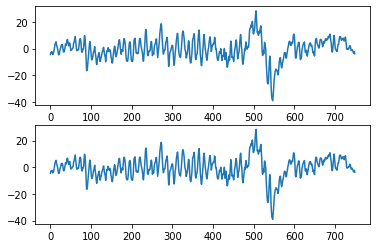

Nadam
EEG act: <class 'torch.nn.modules.activation.ReLU'>


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0   [train_acc] 60.28%   [train_loss]  5.89   [test_acc] 66.57%
 10   [train_acc] 78.89%   [train_loss]  4.05   [test_acc] 73.61%
 20   [train_acc] 83.15%   [train_loss]   3.4   [test_acc] 75.74%
 30   [train_acc] 87.96%   [train_loss]  2.72   [test_acc] 80.28%
 40   [train_acc] 90.28%   [train_loss]  2.18   [test_acc] 82.04%
 50   [train_acc] 90.93%   [train_loss]  1.99   [test_acc] 82.13%
 60   [train_acc]  92.5%   [train_loss]  1.63   [test_acc] 83.43%
 70   [train_acc] 94.07%   [train_loss]  1.38   [test_acc] 80.74%
 80   [train_acc] 94.91%   [train_loss]  1.32   [test_acc] 82.96%
 90   [train_acc] 94.07%   [train_loss]  1.31   [test_acc] 83.52%
 100  [train_acc] 94.91%   [train_loss]  1.29   [test_acc]  81.2%
 110  [train_acc] 94.72%   [train_loss]  1.15   [test_acc] 84.63%
 120  [train_acc] 96.57%   [train_loss]  1.03   [test_acc] 84.26%
 130  [train_acc] 95.83%   [train_loss]  0.98   [test_acc] 84.72%
 140  [train_acc]  96.3%   [train_loss]  0.83   [test_acc] 83.89%
 150  [tra

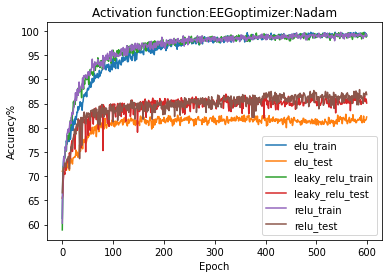

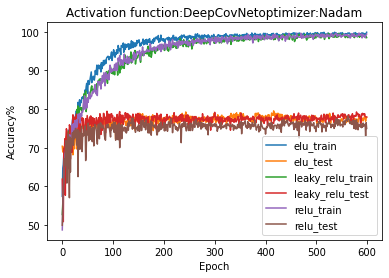

EEG _ elu : 82.78 %
EEG _ leaky_relu : 86.94 %
EEG _ relu : 87.87 %
DeepCovNet _ elu : 79.54 %
DeepCovNet _ leaky_relu : 79.44 %
DeepCovNet _ relu : 78.24 %


In [10]:
for opt in ['Nadam']: #['RMSprop','SGD','adagrad']
  for batch in [128]: #[16,128]
    param = load_data({"Batch size":batch,"Learning rate":1e-3,"Epochs":600,'optimizer':opt})
    param['loss'] = nn.CrossEntropyLoss()
    param['bound'] = 87
    print(param['optimizer'])
    Acc_list_relu = Run(param,act_list=["relu","elu","leaky_relu"])
    show_result(Acc_list_relu,param['optimizer'])

In [ ]:
model = Acc_list_relu["EEG"]['relu']['model']
torch.save(model.state_dict(), "./model/eeg_relu.pth")